In [136]:
import pandas as pd
import numpy as np
training = pd.read_excel('training.xlsx')
scoring = pd.read_excel("scoring.xlsx")
californiaUtilityData = pd.read_excel("californiaUtilityData.xlsx")
californiaUtilityData


,year,avgGasPerThermUSD,avgElecKWHUSD,avgLowSulfurDieselUSDPerGallon,avgPriceGasolineUnleadedRegularUSDPerGallon
0,1996,0.584667,0.127667,0.780333,1.409778
1,1997,0.680333,0.127000,0.678333,1.382250
2,1998,0.672667,0.113417,0.485917,1.239083
3,1999,0.709250,0.115000,0.631000,1.443583
4,2000,0.880000,0.115000,0.977917,1.765417
5,2001,1.073750,0.148417,0.816000,1.733250
6,2002,0.729167,0.160250,0.749917,1.526333
7,2003,1.002917,0.156000,0.914667,1.866750
8,2004,1.001667,0.144833,1.317667,2.113667
9,2005,1.327000,0.149417,1.789083,2.469583


In [137]:
californiaUtilityData = californiaUtilityData.rename(columns={"year": "modelYear"})

In [138]:
training.shape

(41053, 10)

In [139]:
scoring.shape

(7546, 10)

#Using the mean as our dataset does not contain that many outliers etc.

In [140]:
training = training.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
    "Vehicle Population:": "vehiclePopulation"
})

training = training.drop(columns=['Region'])
# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group = training.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['modelYear'] = training['modelYear'].fillna(mode_per_group)
# Update unknown values in Electric Mile Range to use mode from Fuel Type, Fuel Technology subcategories
mode_electricMileRange = training.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['electricMileRange'] = training['electricMileRange'].where(training['electricMileRange'] != 'Unknown', mode_electricMileRange)
training = pd.get_dummies(training,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange","numVehiclesReg"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange", "numVehiclesReg" ],
                            prefix_sep="_")
training = pd.merge(training, californiaUtilityData, on="modelYear", how="left")

y_scoring_actual = training['Vehicle Population']

In [141]:
training

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,electricMileRange_Unknown,numVehiclesReg_1,numVehiclesReg_2,numVehiclesReg_3,numVehiclesReg_Unknown,numVehiclesReg_≥4,avgGasPerThermUSD,avgElecKWHUSD,avgLowSulfurDieselUSDPerGallon,avgPriceGasolineUnleadedRegularUSDPerGallon
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.615583,0.234917,1.306917,3.118000
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.486333,0.217333,2.008417,3.705417
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.449750,0.209750,2.127833,3.641833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN


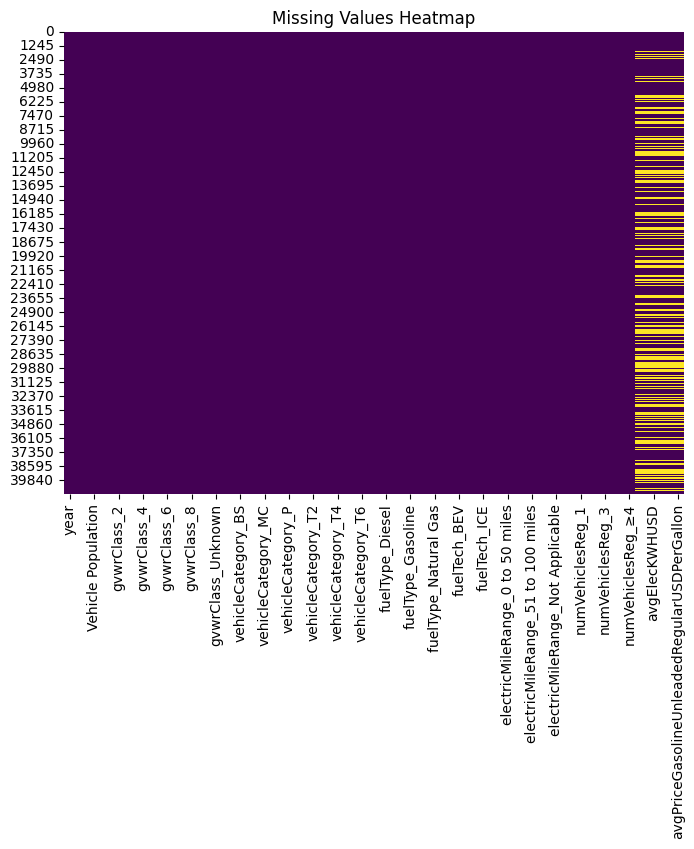

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(training.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [143]:
training

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,electricMileRange_Unknown,numVehiclesReg_1,numVehiclesReg_2,numVehiclesReg_3,numVehiclesReg_Unknown,numVehiclesReg_≥4,avgGasPerThermUSD,avgElecKWHUSD,avgLowSulfurDieselUSDPerGallon,avgPriceGasolineUnleadedRegularUSDPerGallon
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.615583,0.234917,1.306917,3.118000
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.486333,0.217333,2.008417,3.705417
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.449750,0.209750,2.127833,3.641833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN


In [144]:
training

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,electricMileRange_Unknown,numVehiclesReg_1,numVehiclesReg_2,numVehiclesReg_3,numVehiclesReg_Unknown,numVehiclesReg_≥4,avgGasPerThermUSD,avgElecKWHUSD,avgLowSulfurDieselUSDPerGallon,avgPriceGasolineUnleadedRegularUSDPerGallon
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.615583,0.234917,1.306917,3.118000
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,False,True,False,False,False,False,1.615583,0.234917,1.306917,3.118000
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.486333,0.217333,2.008417,3.705417
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,False,False,False,False,False,True,1.449750,0.209750,2.127833,3.641833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,False,False,False,True,False,False,NaN,NaN,NaN,NaN
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,NaN,NaN,NaN,NaN


In [145]:
print(training.columns.tolist())


['year', 'modelYear', 'Vehicle Population', 'gvwrClass_1', 'gvwrClass_2', 'gvwrClass_3', 'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6', 'gvwrClass_7', 'gvwrClass_8', 'gvwrClass_Not Applicable', 'gvwrClass_Unknown', 'vehicleCategory_B', 'vehicleCategory_BS', 'vehicleCategory_BT', 'vehicleCategory_MC', 'vehicleCategory_MH', 'vehicleCategory_P', 'vehicleCategory_T1', 'vehicleCategory_T2', 'vehicleCategory_T3', 'vehicleCategory_T4', 'vehicleCategory_T5', 'vehicleCategory_T6', 'vehicleCategory_T7', 'fuelType_Diesel', 'fuelType_Electric', 'fuelType_Gasoline', 'fuelType_Hydrogen', 'fuelType_Natural Gas', 'fuelType_Unknown', 'fuelTech_BEV', 'fuelTech_FCEV', 'fuelTech_ICE', 'fuelTech_PHEV', 'electricMileRange_0 to 50 miles', 'electricMileRange_101 to 150 miles', 'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles', 'electricMileRange_Not Applicable', 'electricMileRange_Unknown', 'numVehiclesReg_1', 'numVehiclesReg_2', 'numVehiclesReg_3', 'numVehiclesReg_Unknown', 'numVehiclesReg_≥4

In [146]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'training' is your dataset


In [147]:
X = training.drop(columns=["Vehicle Population"])  # Features
y = training["Vehicle Population"]  # Target variable


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


In [149]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': int(81.94562010166663),
    'max_depth': int(10.32559568840523),
    'learning_rate': 0.3,
    'n_estimators': int(117.14689484673896),
    'min_child_samples': int(9.787194938765415),
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'feature_pre_filter': False 
}

model = lgb.train(params, 
                  train_data, 
                  valid_sets=[valid_data],  
                  valid_names=["validation"],  
                  num_boost_round=1000,
                  )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {evs}")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 32842, number of used features: 50


C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3489.914682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 4110.531370805763
Mean Absolute Error: 724.0037028115083
R-squared: 0.9536636834326528
Mean Squared Error: 16896468.150378305
Explained Variance Score: 0.9536661675901335


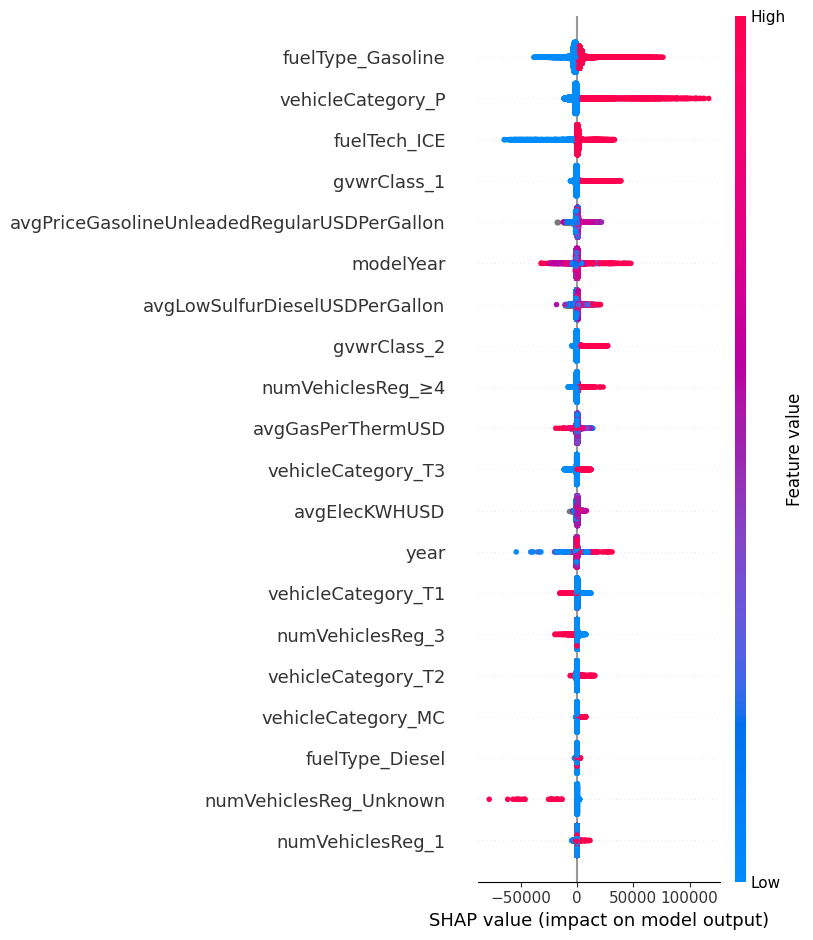

In [150]:
import shap
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)



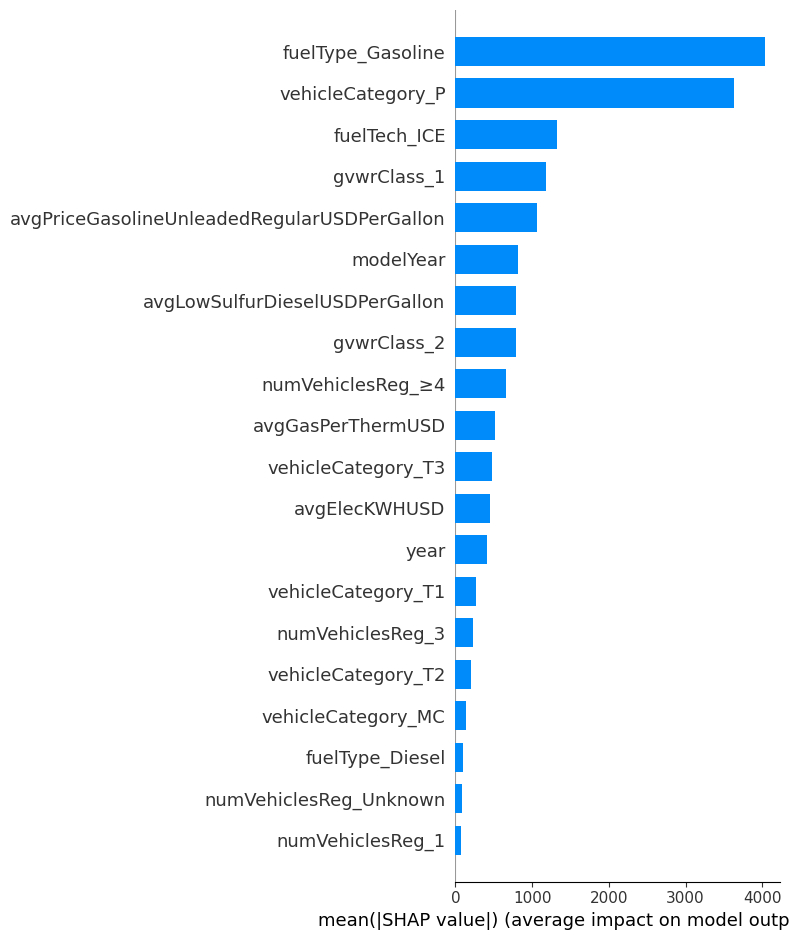

In [151]:
# Plot feature importance using the mean absolute SHAP value per feature
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [152]:
shap_values

array([[-6.12189226e+01, -2.20680556e+03, -3.08541089e+02, ...,
         2.74244915e+02, -9.61907032e+02,  1.03817965e+03],
       [-5.94042943e+01, -4.80184785e+02, -1.35799017e+03, ...,
         2.84683276e+02, -5.98664757e+02, -8.30987571e+02],
       [-1.10324621e+00,  2.67563369e+02, -5.86976308e+02, ...,
         1.53850563e+02,  3.17761606e+02,  4.21825723e+02],
       ...,
       [-1.20615313e+02, -2.68777481e+02, -3.80173736e+02, ...,
         9.86624397e+01, -2.65513763e+02, -3.66485659e+02],
       [-3.90670178e+01, -3.38252169e+02, -2.53018145e+02, ...,
        -1.83920518e+02, -2.34501421e+02, -4.15329171e+02],
       [-6.56686843e+01, -7.95636688e+01, -5.81336143e+02, ...,
         3.26863032e+02,  3.14625197e+02,  3.65111377e+02]])

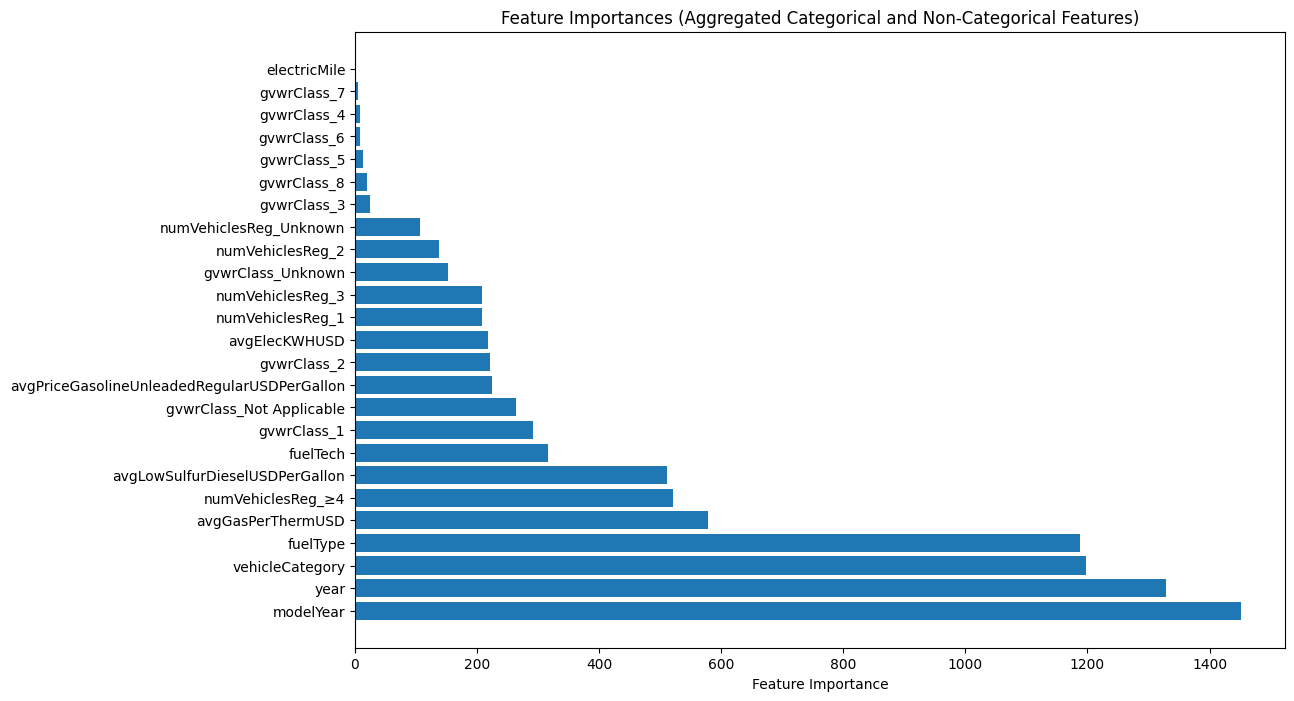

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

feature_importance = model.feature_importance(importance_type='split')
feature_names = X.columns

aggregated_importance = {}

categorical_feature_groups = {
    'vehicleCategory': [col for col in X.columns if col.startswith('vehicleCategory')],
    'fuelType': [col for col in X.columns if col.startswith('fuelType')],
    'fuelTech': [col for col in X.columns if col.startswith('fuelTech')],
    'electricMile': [col for col in X.columns if col.startswith('electricRange')]
}

for cat_feature, cat_columns in categorical_feature_groups.items():
    cat_importance = np.sum([feature_importance[feature_names.get_loc(col)] for col in cat_columns])
    aggregated_importance[cat_feature] = cat_importance


non_categorical_importance = {
    feature: feature_importance[feature_names.get_loc(feature)] 
    for feature in X.columns if not any(feature.startswith(cat) for cat in categorical_feature_groups)
}

aggregated_importances_df = pd.DataFrame({
    'feature': list(aggregated_importance.keys()),
    'importance': list(aggregated_importance.values())
})

non_categorical_importances_df = pd.DataFrame({
    'feature': list(non_categorical_importance.keys()),
    'importance': list(non_categorical_importance.values())
})

combined_importances_df = pd.concat([aggregated_importances_df, non_categorical_importances_df], ignore_index=True)
combined_importances_df = combined_importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(combined_importances_df['feature'], combined_importances_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Aggregated Categorical and Non-Categorical Features)')
plt.show()


In [154]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 4110.531370805763


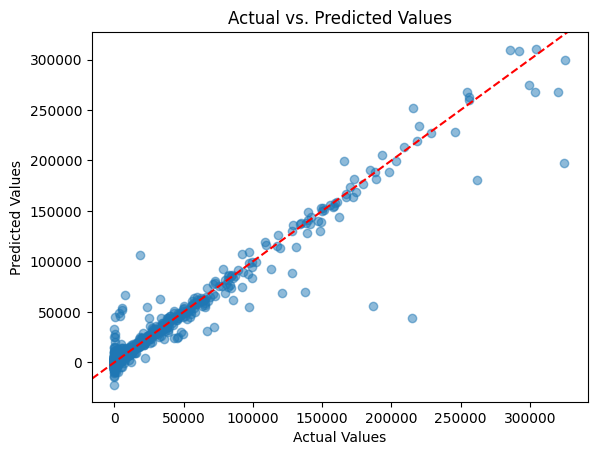

In [155]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed') 
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

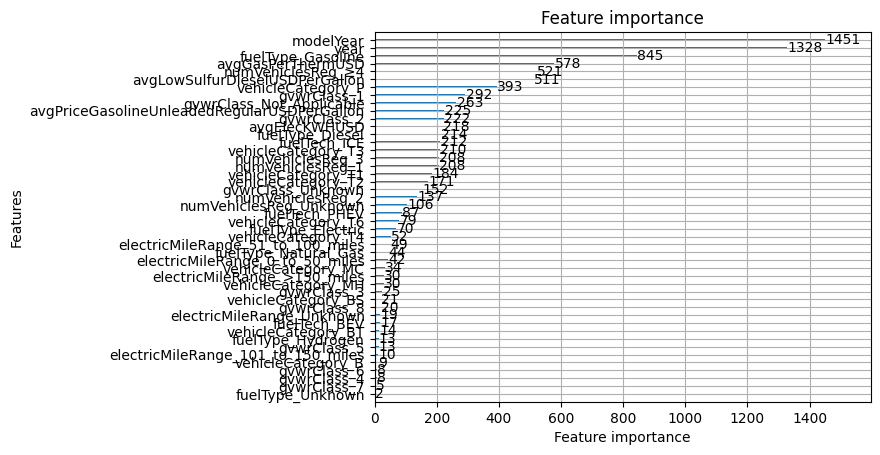

In [156]:
lgb.plot_importance(model)


In [157]:
import pandas as pd

scoring_df = pd.read_excel("scoring.xlsx")

print(scoring_df.head())


   Date Vehicle Category      GVWR Class Fuel Type  Model Year  \
0  2024                P  Not Applicable  Gasoline      2020.0   
1  2024                P  Not Applicable  Gasoline      2021.0   
2  2024                P  Not Applicable  Gasoline      2022.0   
3  2024                P  Not Applicable  Gasoline      2024.0   
4  2024                P  Not Applicable  Gasoline      2023.0   

  Fuel Technology Electric Mile Range  \
0             ICE      Not Applicable   
1             ICE      Not Applicable   
2             ICE      Not Applicable   
3             ICE      Not Applicable   
4             ICE      Not Applicable   

  Number of Vehicles Registered at the Same Address     Region  \
0                                                ≥4  Statewide   
1                                                ≥4  Statewide   
2                                                ≥4  Statewide   
3                                                ≥4  Statewide   
4                         

In [158]:
scoring_df = scoring_df.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
    "Vehicle Population:": "vehiclePopulation"
})

scoring_df = scoring_df.drop(columns=['Region'])
# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group = scoring_df.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring_df['modelYear'] = scoring_df['modelYear'].fillna(mode_per_group)
# Update unknown values in Electric Mile Range to use mode from Fuel Type, Fuel Technology subcategories
mode_electricMileRange = scoring_df.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring_df['electricMileRange'] = scoring_df['electricMileRange'].where(scoring_df['electricMileRange'] != 'Unknown', mode_electricMileRange)
scoring_df = pd.get_dummies(scoring_df,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange","numVehiclesReg"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange", "numVehiclesReg" ],
                            prefix_sep="_")

y_scoring_actual = scoring_df['Vehicle Population']
scoring_df = pd.merge(scoring_df, californiaUtilityData, on="modelYear", how="left")

scoring_df = scoring_df.drop(columns=['Vehicle Population'])
if 'fuelType_Unknown' in X_train.columns and 'fuelType_Unknown' not in scoring_df.columns:
    scoring_df['fuelType_Unknown'] = 0
#training = training.drop(columns=['Vehicle Population'])
if 'numVehiclesReg_Unknown' in X_train.columns and 'numVehiclesReg_Unknown' not in scoring_df.columns:
    scoring_df['numVehiclesReg_Unknown'] = 0

In [159]:
scoring_df

,year,modelYear,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,gvwrClass_8,...,numVehiclesReg_1,numVehiclesReg_2,numVehiclesReg_3,numVehiclesReg_≥4,avgGasPerThermUSD,avgElecKWHUSD,avgLowSulfurDieselUSDPerGallon,avgPriceGasolineUnleadedRegularUSDPerGallon,fuelType_Unknown,numVehiclesReg_Unknown
0,2024,2020.0,False,False,False,False,False,False,False,False,...,False,False,False,True,1.615583,0.234917,1.306917,3.118000,0,0
1,2024,2021.0,False,False,False,False,False,False,False,False,...,False,False,False,True,1.797500,0.256000,2.099083,4.189333,0,0
2,2024,2022.0,False,False,False,False,False,False,False,False,...,False,False,False,True,2.259333,0.303250,3.524667,5.550750,0,0
3,2024,2024.0,False,False,False,False,False,False,False,False,...,False,False,False,True,2.301333,0.396333,2.440250,4.863500,0,0
4,2024,2023.0,False,False,False,False,False,False,False,False,...,False,False,False,True,2.089083,0.338500,2.926000,4.979583,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,2024,1989.0,False,False,False,False,False,False,False,False,...,False,False,True,False,NaN,NaN,NaN,NaN,0,0
7542,2024,1988.0,False,False,False,False,False,False,False,False,...,False,True,False,False,NaN,NaN,NaN,NaN,0,0
7543,2024,1988.0,False,False,False,False,False,False,False,False,...,False,False,True,False,NaN,NaN,NaN,NaN,0,0
7544,2024,1987.0,False,False,False,False,False,False,False,False,...,False,True,False,False,NaN,NaN,NaN,NaN,0,0


In [160]:
len(scoring_df.columns)

50

In [161]:
scoring_df = scoring_df[X_train.columns]

In [162]:
y_scoring_pred = model.predict(scoring_df)

In [163]:
len(scoring_df)

7546

In [164]:
rmse_scoring = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred))

In [165]:
rmse_scoring

5894.420495284642

In [166]:
scoring_df.columns

Index(['year', 'modelYear', 'gvwrClass_1', 'gvwrClass_2', 'gvwrClass_3',
       'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6', 'gvwrClass_7',
       'gvwrClass_8', 'gvwrClass_Not Applicable', 'gvwrClass_Unknown',
       'vehicleCategory_B', 'vehicleCategory_BS', 'vehicleCategory_BT',
       'vehicleCategory_MC', 'vehicleCategory_MH', 'vehicleCategory_P',
       'vehicleCategory_T1', 'vehicleCategory_T2', 'vehicleCategory_T3',
       'vehicleCategory_T4', 'vehicleCategory_T5', 'vehicleCategory_T6',
       'vehicleCategory_T7', 'fuelType_Diesel', 'fuelType_Electric',
       'fuelType_Gasoline', 'fuelType_Hydrogen', 'fuelType_Natural Gas',
       'fuelType_Unknown', 'fuelTech_BEV', 'fuelTech_FCEV', 'fuelTech_ICE',
       'fuelTech_PHEV', 'electricMileRange_0 to 50 miles',
       'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       'numVehiclesReg_1', 'n

In [167]:
X_train.columns

Index(['year', 'modelYear', 'gvwrClass_1', 'gvwrClass_2', 'gvwrClass_3',
       'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6', 'gvwrClass_7',
       'gvwrClass_8', 'gvwrClass_Not Applicable', 'gvwrClass_Unknown',
       'vehicleCategory_B', 'vehicleCategory_BS', 'vehicleCategory_BT',
       'vehicleCategory_MC', 'vehicleCategory_MH', 'vehicleCategory_P',
       'vehicleCategory_T1', 'vehicleCategory_T2', 'vehicleCategory_T3',
       'vehicleCategory_T4', 'vehicleCategory_T5', 'vehicleCategory_T6',
       'vehicleCategory_T7', 'fuelType_Diesel', 'fuelType_Electric',
       'fuelType_Gasoline', 'fuelType_Hydrogen', 'fuelType_Natural Gas',
       'fuelType_Unknown', 'fuelTech_BEV', 'fuelTech_FCEV', 'fuelTech_ICE',
       'fuelTech_PHEV', 'electricMileRange_0 to 50 miles',
       'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       'numVehiclesReg_1', 'n

In [168]:
scoring_df.columns

Index(['year', 'modelYear', 'gvwrClass_1', 'gvwrClass_2', 'gvwrClass_3',
       'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6', 'gvwrClass_7',
       'gvwrClass_8', 'gvwrClass_Not Applicable', 'gvwrClass_Unknown',
       'vehicleCategory_B', 'vehicleCategory_BS', 'vehicleCategory_BT',
       'vehicleCategory_MC', 'vehicleCategory_MH', 'vehicleCategory_P',
       'vehicleCategory_T1', 'vehicleCategory_T2', 'vehicleCategory_T3',
       'vehicleCategory_T4', 'vehicleCategory_T5', 'vehicleCategory_T6',
       'vehicleCategory_T7', 'fuelType_Diesel', 'fuelType_Electric',
       'fuelType_Gasoline', 'fuelType_Hydrogen', 'fuelType_Natural Gas',
       'fuelType_Unknown', 'fuelTech_BEV', 'fuelTech_FCEV', 'fuelTech_ICE',
       'fuelTech_PHEV', 'electricMileRange_0 to 50 miles',
       'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       'numVehiclesReg_1', 'n

In [169]:
X_train.columns

Index(['year', 'modelYear', 'gvwrClass_1', 'gvwrClass_2', 'gvwrClass_3',
       'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6', 'gvwrClass_7',
       'gvwrClass_8', 'gvwrClass_Not Applicable', 'gvwrClass_Unknown',
       'vehicleCategory_B', 'vehicleCategory_BS', 'vehicleCategory_BT',
       'vehicleCategory_MC', 'vehicleCategory_MH', 'vehicleCategory_P',
       'vehicleCategory_T1', 'vehicleCategory_T2', 'vehicleCategory_T3',
       'vehicleCategory_T4', 'vehicleCategory_T5', 'vehicleCategory_T6',
       'vehicleCategory_T7', 'fuelType_Diesel', 'fuelType_Electric',
       'fuelType_Gasoline', 'fuelType_Hydrogen', 'fuelType_Natural Gas',
       'fuelType_Unknown', 'fuelTech_BEV', 'fuelTech_FCEV', 'fuelTech_ICE',
       'fuelTech_PHEV', 'electricMileRange_0 to 50 miles',
       'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       'numVehiclesReg_1', 'n

In [170]:
# Re-run the prediction
y_scoring_pred = model.predict(scoring_df)
# Calculate RMSE
rmse_scoring = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred))
rmse_scoring

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred))
print(f"RMSE: {rmse}")

# Calculate Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_scoring_actual, y_scoring_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_scoring_actual, y_scoring_pred)
print(f"R-squared: {r2}")

# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_scoring_actual, y_scoring_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Explained Variance Score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_scoring_actual, y_scoring_pred)
print(f"Explained Variance Score: {evs}")


RMSE: 5894.420495284642
Mean Absolute Error: 981.794620251573
R-squared: 0.9083125766694706
Mean Squared Error: 34744192.97523165
Explained Variance Score: 0.9083136572825451


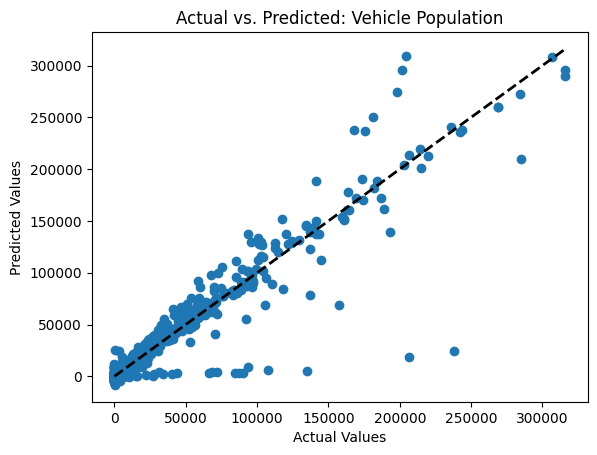

In [171]:
plt.scatter(y_scoring_actual, y_scoring_pred)
plt.plot([min(y_scoring_actual), max(y_scoring_actual)],
         [min(y_scoring_actual), max(y_scoring_actual)], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted: Vehicle Population')
plt.show()


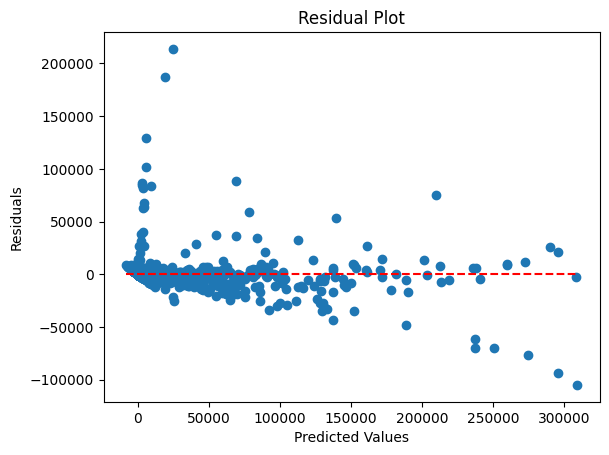

In [172]:
residuals = y_scoring_actual - y_scoring_pred

plt.scatter(y_scoring_pred, residuals)
plt.hlines(y=0, xmin=min(y_scoring_pred), xmax=max(y_scoring_pred), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


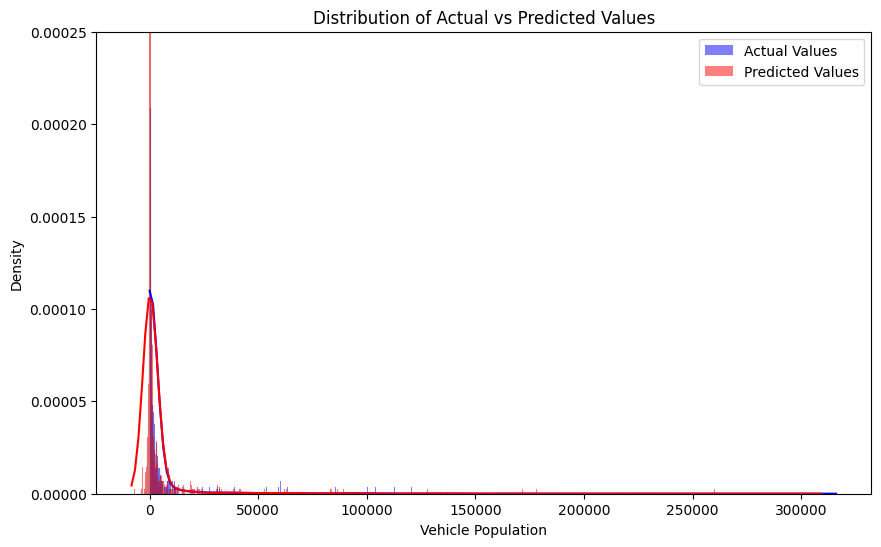

In [173]:
plt.figure(figsize=(10, 6))
sns.histplot(y_scoring_actual, color='blue', kde=True, label='Actual Values', stat='density')
sns.histplot(y_scoring_pred, color='red', kde=True, label='Predicted Values', stat='density')
plt.legend()
plt.title('Distribution of Actual vs Predicted Values')
plt.ylim(0, 0.00025)
plt.show()
